# Импорт библиотек

Устанавливаем psycopg2 для связи с БД (расскоментируйте, если этого пакета еще нет).

In [1]:
#!pip install psycopg2-binary

Импортируем необходимые библиотеки

In [2]:
import copy
import pandas as pd
import numpy as np
import datetime
import psycopg2
import getpass
import matplotlib.pyplot as plt

# Домашнее задание 2

In [3]:
with psycopg2.connect(user='postgres',
                      database='postgres',
                      host='localhost',
                      port='5432',
                      password=getpass.getpass('Insert password:')) as connector:

    query = """
    SELECT * FROM(SELECT MAX("CPN") AS "CPN", "ISIN", MAX("BUYBACKDATE") AS BUYBACKDATE, 
                  MAX("BUYBACKPRICE") AS "BUYBACKPRICE" FROM PUBLIC.quotes where "CPN" !='0'
                  group by "ISIN") AS a
            INNER JOIN (SELECT "ISINCode", "FaceValue", "HaveOffer", "AmortisedMty", 
                        "CouponPerYear", "NumCoupons", "EndMtyDate", "CouponType", "IssuerName"
                        FROM public.bond_description  where "CouponPerYear" >'0'
                        and "Status"!='Погашен'  and "Status"!='Размещается'
                        and "CouponType" != 'Переменный' and "CouponType" != 'Прочий') AS b
            ON a."ISIN" = b."ISINCode"; 
    """

    data = pd.read_sql_query(query, connector)

data.BUYBACKPRICE = data.BUYBACKPRICE.fillna(0)
data.head(5)

Insert password:········


,CPN,ISIN,buybackdate,BUYBACKPRICE,ISINCode,FaceValue,HaveOffer,AmortisedMty,CouponPerYear,NumCoupons,EndMtyDate,CouponType,IssuerName
0,40.11,RU000A0JNYN1,None,0,RU000A0JNYN1,1000.0,False,False,2,31,2022-06-11,Фиксированный,Москва Правительство
1,40.11,RU000A0JNYP6,None,$0.00,RU000A0JNYP6,1000.0,True,False,2,21,2017-06-14,Фиксированный,Москва Правительство
2,40.33,RU000A0JPZ50,None,0,RU000A0JPZ50,1000.0,True,False,2,16,2016-09-22,Фиксированный,Москва Правительство
3,55.65,RU000A0JQ6S9,None,0,RU000A0JQ6S9,1000.0,True,False,2,14,2016-06-20,Постоянный,РЖД
4,57.34,RU000A0JQ7X7,2016-07-18,$100.00,RU000A0JQ7X7,1000.0,True,False,2,20,2019-07-15,Индексируемый,РЖД


In [4]:
def payments_scheme_count(row_data, given_date, return_type=False):
    '''This function counts the scheme of payments for one ISIN at given time point
    
    row_data: the one row from the dataframe like data above (pd.Series object)
    given_date: the datetime.date formated value
    return_type: return the type of coupon?
    return: the one row of the payments scheme in the pd.DataFrame object
    '''

    isin = row_data['ISIN']
    end_date = row_data['buybackdate'] if row_data['buybackdate'] is not None else row_data['EndMtyDate']
    last_payment = row_data['BUYBACKPRICE'] if row_data['buybackdate'] is not None  else  row_data['FaceValue']
    coupon_period = 365 / row_data['CouponPerYear']
    if end_date <= given_date:    #What is given date
        dates = [end_date]
        if row_data['buybackdate']:
            payments = [last_payment]
        else:
            payments = [last_payment + row_data['CPN']]
    else:
        dates = []
        payments = []
        
    for coupon_interval in range(1, row_data['NumCoupons']):
        date = row_data['EndMtyDate'] - datetime.timedelta(days=round(coupon_period * coupon_interval))
        if date <= given_date and date <= end_date:
            dates.append(date)
            
            if row_data['AmortisedMty']:
                coupon = (1 + row_data['CPN']) * last_payment / row_data['NumCoupons'] 
                last_payment = last_payment * (1 - 1 / row_data['NumCoupons'])
            else:
                coupon = row_data['CPN']
            payments.append(coupon)

    payments_scheme = pd.DataFrame(sorted(list(zip(dates, payments)))).transpose()
    if not payments_scheme.empty:
        payments_scheme.columns = payments_scheme.iloc[0]
        payments_scheme = payments_scheme.drop(payments_scheme.index[0])
        payments_scheme.index = [isin]
    
    # it is necessary for the third task
    if not return_type:
        return payments_scheme
    
    if row_data['AmortisedMty']:
        coupon_type = 'Amortised'
    elif row_data['CPN'] == 0:
        coupon_type = 'Zero'
    else:
        coupon_type = 'Plain'
    return payments_scheme, coupon_type

In [5]:
def payments_scheme_concate(scheme_first, scheme_second):
    '''This function concates the schemes (the returns of function payments_scheme_count) in one dataframe

    scheme_first (the return of payments_scheme_count)
    scheme_second (the return of payments_scheme_count)
    return: scheme - the same scheme of pd.DataFrame object
    '''
    scheme = pd.concat((scheme_first, scheme_second), sort=True)
    scheme = scheme.fillna(0)
    return scheme

In [6]:
def full_payments_matrix_construction(data_int, date, issuer, return_type=False):
    '''This function construct the necessary result
    
    data_int - the pd.DataFrame object as at the top of this notebook
    date - the date of format datetime.date
    issuer - the issuer name
    return: the pd.DataFrame object of all payments scheme 
    '''
    
    data = copy.deepcopy(data_int.loc[data_int['IssuerName'] == issuer])
    tmp = True
    for index, row in data.iterrows():
        if tmp:
            if not return_type:
                result_frame = payments_scheme_count(row, date)
            else:
                result_frame, coupon_type = payments_scheme_count(row, date, return_type=True)
                result_frame['type'] = coupon_type
            tmp = False
        else:
            if not return_type:
                scheme = payments_scheme_count(row, date)
                if not scheme.empty:
                    result_frame = payments_scheme_concate(result_frame, scheme)
            else:
                scheme, coupon_type = payments_scheme_count(row, date, return_type=True)
                scheme['type'] = coupon_type
                if not scheme.empty:
                    result_frame = payments_scheme_concate(result_frame, scheme)
                
    return result_frame

In [7]:
full_payments_matrix_construction(data, date=datetime.date(2020,2,13), issuer='Москва Правительство')

,2007-06-15,2007-06-17,2007-12-15,2007-12-16,2008-06-14,2008-06-16,2008-12-13,2008-12-16,2009-03-25,2009-06-14,...,2017-11-23,2017-12-12,2018-02-22,2018-05-25,2018-06-12,2018-08-24,2018-11-23,2018-12-11,2019-06-12,2019-12-12
RU000A0JNYN1,40.11,0.00,40.11,0.00,40.11,0.00,40.11,0.00,0.00,40.11,...,0.00,40.11,0.00,0.00,40.11,0.00,0.00,40.11,40.11,40.11
RU000A0JNYP6,0.00,40.11,0.00,40.11,0.00,40.11,0.00,40.11,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
RU000A0JPZ50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,40.33,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
RU000A0JQHM1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,36.55,0.00,36.55,36.55,0.00,36.55,1036.55,0.00,0.00,0.00
RU000A0JTXW1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


# Домашнее задание 3

In [8]:
def all_emmisions(data, date, issuer):
    '''Construction the dataset of all emissions by coupon type
    
    data - the initial dataframe (see the top of the notebook)
    date - the datetime.date value
    issuer - the issuer name
    return: pd.DataFrame object
    '''
    data_all = full_payments_matrix_construction(data, date, issuer, return_type=True)
    tmp = True
    for index, row in data_all.iterrows():
        if tmp:
            frame = pd.DataFrame(row.loc[row.index != 'type'])
            frame.columns = [row['type']]
#             frame = frame.reset_index()
            frame = frame.reset_index().rename(columns={frame.index.name:'index'})
            tmp = False
            print(frame)
        else:
            addition = pd.DataFrame(row.loc[row.index != 'type'])
            addition.columns = [row['type']]
#             addition = addition.reset_index()
            addition = addition.reset_index().rename(columns={addition.index.name:'index'})
            frame = pd.concat((frame, addition))
          
    frame.index = pd.to_datetime(frame['index'])
    frame = frame.groupby([pd.TimeGrouper('M')]).sum()
            
    frame = frame.replace(0, np.nan)
    frame = frame.dropna(how='all', axis=0)
    frame = frame.replace(np.nan, 0)
    
    frame = frame.sort_index()
    
    frame.index = frame.index.date
    
    return frame

In [9]:
emmision = all_emmisions(data, datetime.date(2010,1,1), 'Москва Правительство')
emmision

         index  Plain
0   2007-06-15  40.11
1   2007-12-15  40.11
2   2008-06-14  40.11
3   2008-12-13  40.11
4   2009-06-14  40.11
5   2009-12-14  40.11
6   2007-06-17      0
7   2007-12-16      0
8   2008-06-16      0
9   2008-12-16      0
10  2009-06-16      0
11  2009-12-15      0
12  2009-03-25      0
13  2009-09-24      0


/Users/a1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)


,Plain
2007-06-30,80.22
2007-12-31,80.22
2008-06-30,80.22
2008-12-31,80.22
2009-03-31,40.33
2009-06-30,80.22
2009-09-30,40.33
2009-12-31,80.22


<Figure size 432x288 with 0 Axes>

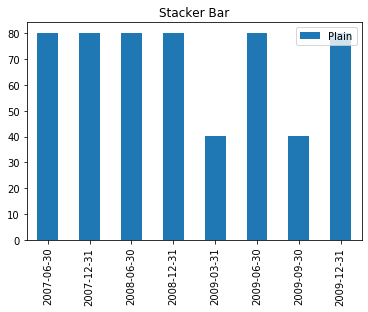

In [10]:
plt.figure()
emmision.plot.bar(stacked=True)
plt.title('Stacker Bar')
plt.show()